# Data Analysis

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import json
from collections import Counter
import statistics
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
def sanitize_df2(df):

    df = df.replace({np.nan: ''})
    df = df.replace({np.NaN: ''})
    df = df.replace({np.NAN: ''})
    df = df.replace({"NULL": ''})
    df = df.replace({"": ''})
    df = df.replace({" ": ''})
    df = df.fillna('')
    
    return df

In [3]:
# fields extracted from Twitter API
sources = ['AAAJ AAJC', 'AILANational', 'BAJItweet', 'BreitbartNews', 'FAIRImmigration',
           'ICEgov', 'IngrahamAngle', 'splcenter', 'StatePRM', 'TuckerCarlson', 'UNHCRUSA']

## Load the data

In [4]:
labeled_tweets_by_source = {}

for source in sources:
    df = pd.read_csv('XMP_dataset_dataverse/{}.csv'.format(source), dtype={'ID': 'str'})
    
    df = sanitize_df2(df)
    df = df.drop(columns=['Unnamed: 0'])
    dct = df.to_dict()

    labeled_tweets_by_source[source] = []
    for row_i in range(len(dct['ID'])):
        tweet_labels = []
        for l in range(34):
            if dct['rating_labeler{}'.format(l+1)][row_i] != '':
                label = {'ID': dct['ID'][row_i],
                         'xm_rating': dct['rating_labeler{}'.format(l+1)][row_i],
                         'relevance_rating': dct['relevant_to_foreigners?_labeler{}'.format(l+1)][row_i],
                         'labeler': 'labeler' + str(l+1)}
                tweet_labels.append(label)
        labeled_tweets_by_source[source].append(tweet_labels)
        
with open('labeled_tweets_by_source.json', 'w') as f:
    json.dump(labeled_tweets_by_source, f)

## Descriptive statistics

### How many tweets were labeled?

In [5]:
labeled_tweet_stats_by_source = {}
total_number_of_labels = 0
for source in sources:
    labeled_tweets = labeled_tweets_by_source[source]
    at_least_1 = [len(lst) for lst in labeled_tweets if len(lst) > 0]
    assert len(labeled_tweets) == len(at_least_1)
    at_least_2 = [len(lst) for lst in labeled_tweets if len(lst) > 1]
    at_least_3 = [len(lst) for lst in labeled_tweets if len(lst) > 2]
    labeled_tweet_stats_by_source[source] = {'at_least_2_labels': len(at_least_2),
                                             'at_least_3_labels': len(at_least_3),
                                             'at_least_1_label': len(at_least_1)}
    # total_number_of_labels += sum(at_least_2)
    total_number_of_labels += sum(at_least_1)
labeled_tweet_stats_by_source_df = pd.DataFrame.from_dict(labeled_tweet_stats_by_source) 
labeled_tweet_stats_by_source_df['Total'] = labeled_tweet_stats_by_source_df.sum(axis=1)
labeled_tweet_stats_by_source_df.T

,at_least_2_labels,at_least_3_labels,at_least_1_label
AAAJ AAJC,785,663,882
AILANational,701,570,748
BAJItweet,471,438,474
BreitbartNews,789,695,789
FAIRImmigration,728,701,833
ICEgov,661,658,661
IngrahamAngle,514,392,607
splcenter,623,582,645
StatePRM,524,514,553
TuckerCarlson,828,820,829


In [6]:
total_number_of_labels

39626

### How many tweets were labeled by $n$-many labelers?

In [7]:
tweet_label_counts_by_source = {}
for source in sources:
    labeled_tweets = labeled_tweets_by_source[source]
    label_counts_freqs = Counter(len(lst) for lst in labeled_tweets)
    tweet_label_counts_by_source[source] = {n: label_counts_freqs.get(n, 0) for n in range(1, 19)}

tweet_label_counts_by_source_df = pd.DataFrame.from_dict(tweet_label_counts_by_source) 
tweet_label_counts_by_source_df['Total'] = tweet_label_counts_by_source_df.sum(axis=1)
tweet_label_counts_by_source_df

,AAAJ AAJC,AILANational,BAJItweet,BreitbartNews,FAIRImmigration,ICEgov,IngrahamAngle,splcenter,StatePRM,TuckerCarlson,UNHCRUSA,Total
1,97,47,3,0,105,0,93,22,29,1,31,428
2,122,131,33,94,27,3,122,41,10,8,18,609
3,329,99,8,220,251,52,194,66,54,124,94,1491
4,92,50,101,91,58,235,168,192,32,282,45,1346
5,53,40,40,55,89,80,12,79,4,51,50,553
6,78,83,63,43,95,49,10,29,32,45,102,629
7,12,247,62,38,108,34,3,67,141,64,51,827
8,6,16,19,100,10,66,5,58,76,64,22,442
9,28,18,103,62,16,73,0,60,13,42,11,426
10,5,7,24,52,14,64,0,16,2,14,10,208


In [8]:
tweet_label_counts_by_source_df.sum()

AAAJ AAJC           882
AILANational        748
BAJItweet           474
BreitbartNews       789
FAIRImmigration     833
ICEgov              661
IngrahamAngle       607
splcenter           645
StatePRM            553
TuckerCarlson       829
UNHCRUSA            439
Total              7460
dtype: int64

## IRR analyses
For inter-rater reliability scores we use Krippendorff alpha and the Python implementation of the metric by [Thomas Grill](https://github.com/grrrr/krippendorff-alpha/tree/master).

In [5]:
from krippendorff_alpha import krippendorff_alpha, nominal_metric, interval_metric, ratio_metric

### Krippendorff alpha

In [6]:
all_labelers = ['labeler{}'.format(i+1) for i in range(34)]
matrices_by_source = []
for source in sources:
    labeled_tweets = labeled_tweets_by_source[source]
    filtered_labeled_tweets = []
    relevant_labelers = []
    for lst in labeled_tweets:
        if len(lst) > 1:
            filtered_labeled_tweets.append(lst)
            relevant_labelers += [dct['labeler'] for dct in lst]
    relevant_labelers = sorted(set(relevant_labelers), key=lambda l: int(l[7:]))
    matrix = []
    for i in range(len(relevant_labelers)):
        row = []
        for j in range(len(filtered_labeled_tweets)):
            found = False
            for label in filtered_labeled_tweets[j]:
                if label['labeler'] == relevant_labelers[i] and not found:
                    found = True
                    row.append(int(label['xm_rating']))
            if not found:
                row.append('*')
        matrix.append(row) 

    irr_nominal = krippendorff_alpha(matrix, nominal_metric, missing_items='*')
    irr_interval = krippendorff_alpha(matrix, interval_metric, missing_items='*')
    # irr_ratio = krippendorff_alpha(matrix, ratio_metric, missing_items='*')
    print(source, round(irr_interval, 3), round(irr_nominal, 3))

AAAJ AAJC 0.568 0.44
AILANational 0.433 0.415
BAJItweet 0.56 0.398
BreitbartNews 0.59 0.471
FAIRImmigration 0.57 0.444
ICEgov 0.621 0.507
IngrahamAngle 0.67 0.603
splcenter 0.565 0.43
StatePRM 0.324 0.249
TuckerCarlson 0.633 0.457
UNHCRUSA 0.384 0.33


### Get deviators

In [7]:
deviators_by_source = {}
for source in sources:
    labeler_disagreements_count = {}
    tweets = labeled_tweets_by_source[source]
    for labels in tweets:
        xm_ratings = [dct['xm_rating'] for dct in labels]
        labelers = [dct['labeler'] for dct in labels]
        xm_rating_mean = sum(xm_ratings)/len(labels)
        if len(labels) >= 2:
            xm_rating_stdev = statistics.stdev(xm_ratings)
            for i in range(len(xm_ratings)):
                rating = xm_ratings[i]
                labeler = labelers[i]
                if labeler not in labeler_disagreements_count:
                    labeler_disagreements_count[labeler] = 0
                if abs(rating-xm_rating_mean) > xm_rating_stdev:
                    labeler_disagreements_count[labeler] += 1
        if len(labels) == 1 and labelers[0] not in labeler_disagreements_count:
            labeler_disagreements_count[labelers[0]] = 0
        
    disagreement_counts = [labeler_disagreements_count[l] for l in labeler_disagreements_count]
    disagreements_mean = sum(disagreement_counts)/len(disagreement_counts)
    disagreements_stdev = statistics.stdev(disagreement_counts)

    deviators = []
    for labeler in labeler_disagreements_count:
        if abs(labeler_disagreements_count[labeler] - disagreements_mean) > disagreements_stdev:
            deviators.append(labeler)
    print(source, deviators)
    deviators_by_source[source] = deviators  

AAAJ AAJC ['labeler20', 'labeler23', 'labeler4', 'labeler15', 'labeler9']
AILANational ['labeler4', 'labeler14', 'labeler16', 'labeler17', 'labeler23', 'labeler24', 'labeler30', 'labeler31', 'labeler3']
BAJItweet ['labeler4', 'labeler16', 'labeler17', 'labeler20', 'labeler31', 'labeler25', 'labeler30', 'labeler28', 'labeler21']
BreitbartNews ['labeler25', 'labeler30', 'labeler28']
FAIRImmigration ['labeler4', 'labeler23', 'labeler24', 'labeler30']
ICEgov ['labeler13', 'labeler17', 'labeler18', 'labeler20', 'labeler23', 'labeler4', 'labeler21', 'labeler29']
IngrahamAngle ['labeler21']
splcenter ['labeler5', 'labeler16', 'labeler17', 'labeler24', 'labeler11', 'labeler21', 'labeler28']
StatePRM ['labeler3', 'labeler4', 'labeler13', 'labeler16', 'labeler17', 'labeler19']
TuckerCarlson ['labeler18', 'labeler21', 'labeler28']
UNHCRUSA ['labeler4', 'labeler23', 'labeler3']


### Krippendorff alpha without deviators

In [8]:
all_labelers = ['labeler{}'.format(i+1) for i in range(34)]
matrices_by_source = []
for source in sources:
    labeled_tweets = labeled_tweets_by_source[source]
    filtered_labeled_tweets = []
    relevant_labelers = []
    for lst in labeled_tweets:
        if len(lst) > 1:
            filtered_labeled_tweets.append([dct for dct in lst if dct['labeler'] not in deviators_by_source[source]])
            relevant_labelers += [dct['labeler'] for dct in lst if dct['labeler'] not in deviators_by_source[source]]
    relevant_labelers = sorted(set(relevant_labelers), key=lambda l: int(l[7:]))
    matrix = []
    for i in range(len(relevant_labelers)):
        row = []
        for j in range(len(filtered_labeled_tweets)):
            found = False
            for label in filtered_labeled_tweets[j]:
                if label['labeler'] == relevant_labelers[i] and not found:
                    found = True
                    row.append(int(label['xm_rating']))
            if not found:
                row.append('*')
        matrix.append(row) 

    irr_nominal = krippendorff_alpha(matrix, nominal_metric, missing_items='*')
    irr_interval = krippendorff_alpha(matrix, interval_metric, missing_items='*')
    # irr_ratio = krippendorff_alpha(matrix, ratio_metric, missing_items='*')
    print(source, round(irr_interval, 3), round(irr_nominal, 3))

AAAJ AAJC 0.616 0.49
AILANational 0.545 0.52
BAJItweet 0.622 0.459
BreitbartNews 0.685 0.577
FAIRImmigration 0.641 0.524
ICEgov 0.629 0.496
IngrahamAngle 0.778 0.734
splcenter 0.624 0.513
StatePRM 0.345 0.265
TuckerCarlson 0.682 0.579
UNHCRUSA 0.466 0.443


### Krippendorff alpha for inital set of labelers

In [13]:
all_labelers = ['labeler{}'.format(i+1) for i in range(24)]
matrices_by_source = []
for source in sources:
    labeled_tweets = labeled_tweets_by_source[source]
    filtered_labeled_tweets = []
    relevant_labelers = []
    for lst in labeled_tweets:
        if len(lst) > 1:
            filtered_labeled_tweets.append(lst)
            relevant_labelers += [dct['labeler'] for dct in lst if dct['labeler'] in all_labelers]
    relevant_labelers = sorted(set(relevant_labelers), key=lambda l: int(l[7:]))
    matrix = []
    for i in range(len(relevant_labelers)):
        row = []
        for j in range(len(filtered_labeled_tweets)):
            found = False
            for label in filtered_labeled_tweets[j]:
                if label['labeler'] == relevant_labelers[i] and not found:
                    found = True
                    row.append(int(label['xm_rating']))
            if not found:
                row.append('*')
        matrix.append(row) 

    irr_nominal = krippendorff_alpha(matrix, nominal_metric, missing_items='*')
    irr_interval = krippendorff_alpha(matrix, interval_metric, missing_items='*')
    # irr_ratio = krippendorff_alpha(matrix, ratio_metric, missing_items='*')
    print(source, round(irr_interval, 3), round(irr_nominal, 3))

AAAJ AAJC 0.615 0.487
AILANational 0.481 0.482
BAJItweet 0.627 0.477
BreitbartNews 0.716 0.612
FAIRImmigration 0.6 0.471
ICEgov 0.654 0.554
IngrahamAngle 0.688 0.662
splcenter 0.633 0.496
StatePRM 0.363 0.293
TuckerCarlson 0.679 0.545
UNHCRUSA 0.428 0.376


## Visualizations

### Average rating distribution

In [21]:
agg_tweet_ratings = []
for source in labeled_tweets_by_source:
    labeled_tweets = labeled_tweets_by_source[source]
    for tweet_labels in labeled_tweets:
        if len(tweet_labels) > 1:
            avg_xm_rating = statistics.mean([dct['xm_rating'] for dct in tweet_labels])
            agg_relevance_rating = statistics.mean([dct['relevance_rating'] for dct in tweet_labels]) >= 0.5
            agg_tweet_ratings.append({'id': tweet_labels[0]['ID'],
                                      'source': source,
                                      'xm_rating': avg_xm_rating,
                                      'relevance_rating': agg_relevance_rating})

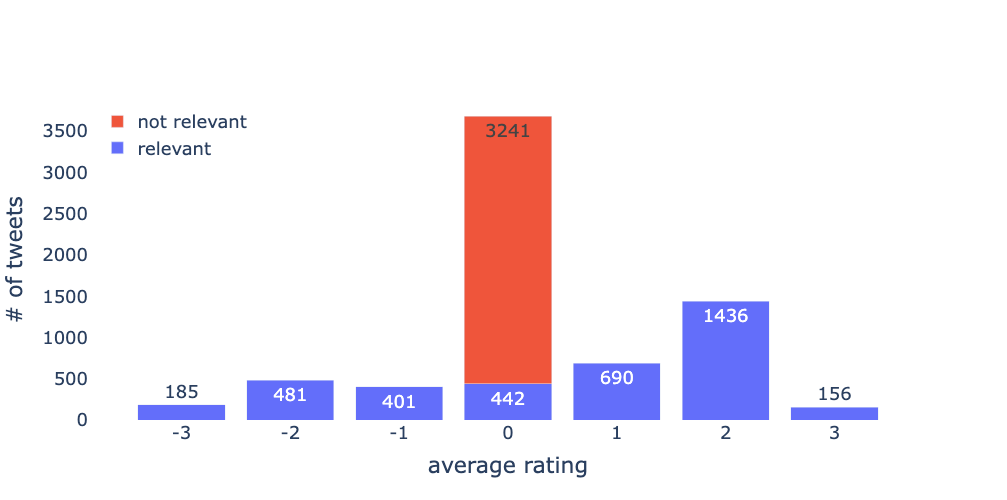

In [22]:
all_source_averages = [elt['xm_rating'] for elt in agg_tweet_ratings if elt['relevance_rating']]
all_source_non_relevants = [0 for elt in agg_tweet_ratings if not elt['relevance_rating']]

bins = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
counts, bins = np.histogram(all_source_averages, bins=bins)

fig = go.Figure()
fig.add_trace(go.Bar(x=[-3, -2, -1, 0, 1, 2, 3], y=counts, name='relevant', text=counts))
fig.add_trace(go.Bar(x=[0], y=[len(all_source_non_relevants)], name='not relevant', text=len(all_source_non_relevants)))

fig.update_layout(width=700,
                  height=500,
                  # title_text='Distribution of averaged tweet ratings per source',
                  yaxis_title="# of tweets",
                  xaxis_title="average rating",
                  showlegend=True,
                  barmode='stack',
                  font=dict(size=18),
                  xaxis = dict(range=[-3.85, 3.85],
                              tickmode = 'array',
                              tickvals = [-3, -2, -1, 0, 1, 2, 3],
                              ticktext = [-3, -2, -1, 0, 1, 2, 3]),
                  legend=dict(yanchor="top",
                              y=0.99,
                              xanchor="left",
                              x=0.01),
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  # bargap = 0.1
                  )
fig.show()

#### Counts of non-relevant tweets by source

In [23]:
len(all_source_averages), len(all_source_non_relevants)

(3791, 3241)

In [24]:
for source in sources:
    print(source, sum(1 for elt in agg_tweet_ratings 
                            if not elt['relevance_rating'] and elt['source'] == source))

AAAJ AAJC 397
AILANational 60
BAJItweet 124
BreitbartNews 716
FAIRImmigration 39
ICEgov 197
IngrahamAngle 472
splcenter 524
StatePRM 11
TuckerCarlson 686
UNHCRUSA 15


### Box plot of average XM rating by source for relevant tweets

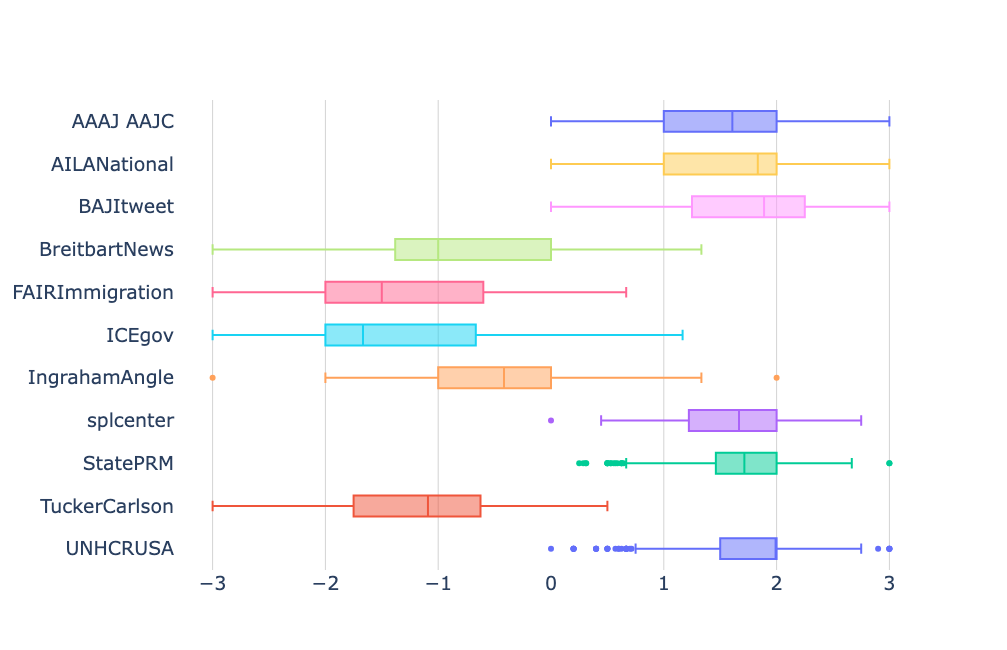

In [25]:
fig = go.Figure()
for source in sources[::-1]:
    fig.add_trace(go.Box(x=[elt['xm_rating'] for elt in agg_tweet_ratings 
                            if elt['relevance_rating'] and elt['source'] == source], 
                         name=source))

fig.update_layout(width=750,
                  height=650,
                  # title_text='Distribution of averaged tweet ratings per source for tweets related to foreigners ',
                  showlegend=False,
                  font=dict(size=19),
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  # paper_bgcolor='rgba(0, 0, 0, 0)',
                 )
fig.update_xaxes(
    gridcolor='lightgrey'
)


fig.show()

#### Save aggregate tweet rating information

In [26]:
with open('tweet_id_to_clean_text.json') as f:
    tweet_id_to_clean_text = json.load (f)

for tweet in agg_tweet_ratings:
    tweet_id = tweet['id']
    source = tweet['source']
    tweet['clean_text'] = tweet_id_to_clean_text[source][tweet_id]['clean_text']
    tweet['clean_text_with_sentiment'] = tweet_id_to_clean_text[source][tweet_id]['clean_text_with_sentiment']
    
with open('agg_tweet_ratings.json', 'w') as f:
    json.dump({"version": "0.1.0",
                "data": agg_tweet_ratings}, f)

In [27]:
agg_tweet_ratings[11]

{'id': '1276979595305156608',
 'source': 'AAAJ AAJC',
 'xm_rating': 0.8333333333333334,
 'relevance_rating': True,
 'clean_text': ". to Why are you here [at instead of Pres. Trump? Gov. says it's because he is a microcosm of the AAPI community, and adds that Trump is going out meeting people in person, not virtually. ",
 'clean_text_with_sentiment': ". to Why are you here [at instead of Pres. Trump? Gov. says it's because he is a microcosm of the AAPI community, and adds that Trump is going out meeting people in person, not virtually.  this tweet is mostly neutral and hateful and contains mostly disgust."}

In [28]:
agg_tweet_ratings = []
with open('agg_tweet_ratings.json') as f:
    for tweet in json.load(f)['data']:
        if tweet['relevance_rating']:
            agg_tweet_ratings.append(tweet)
agg_tweet_ratings_df = pd.DataFrame.from_dict(agg_tweet_ratings)
len(agg_tweet_ratings_df)

3791

In [29]:
len(agg_tweet_ratings)

3791